In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import category_encoders as ce
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve

pd.set_option('display.max_columns', 100)
DATA_FOLDER_PATH = "/Users/ritumutaka/J/Categorical_Feature_Encoding_Challenge_II/datas/cat-in-the-dat-ii"
RANDOM_STATE = 2020

/Users/ritumutaka/.conda/envs/Categorical_Feature_Encoding_Challenge_II/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# ターゲットの分布
def count_plot(data_series):
    values = data_series.value_counts()
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    barplot = plt.bar(values.index, values, color='lightgreen', alpha=0.8)
    barplot[1].set_color('darkred')
    
    ax.set_title('Target Distribution')
    ax.annotate("percentage of target 1 : {}%".format(values.sum() / len(values)),
                xy=(0, 0), xycoords='axes fraction',
                xytext=(0, -50), textcoords='offset points',
                va="top", ha="left", color='grey',
                bbox=dict(boxstyle='round', fc="w", ec='w'))
    
    plt.xlabel('Target', fontsize=12, weight='bold')
    plt.show()

def plot_roc(y_true, y_pred, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    print("%s: %s" % (model_name, auc(fpr, tpr)))
    plt.title(model_name)
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.grid()
    plt.show()

In [3]:
print('load data')
%time

MAKE_TARGET_ENCODED_DATA = False

train = pd.read_csv(DATA_FOLDER_PATH + "/train.csv").sort_index(inplace=False)
test = pd.read_csv(DATA_FOLDER_PATH + "/train.csv").sort_index(inplace=False)
sample_submission = pd.read_csv(DATA_FOLDER_PATH + "/sample_submission.csv", index_col=0)

if not MAKE_TARGET_ENCODED_DATA:
    train_X = pd.read_csv(DATA_FOLDER_PATH + "/train_X_TargetEncoded.csv", index_col=0)
    train_y = train['target']
    test_X = pd.read_csv(DATA_FOLDER_PATH + "/test_X_TargetEncoded.csv", index_col=0)
elif MAKE_TARGET_ENCODED_DATA:
    # ターゲットエンコードしてデータを作成
    train_X, train_y = train.drop(['id', 'target'], axis=1), train['target']
    test_X = test.drop(['id'], axis=1)
    
    # ターゲットエンコーディング
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
    encode_features = list(train_X.columns)
    smoothing = 0.20
    
    #  trainデータをエンコード
    oof = pd.DataFrame([])
    for tr_index, oof_index in skf.split(train_X, train_y):
        ce_target_encoder = ce.TargetEncoder(cols=encode_features, smoothing=smoothing)
        ce_target_encoder.fit(train_X.iloc[tr_index, :], train_y.iloc[tr_index])
        oof_part = ce_target_encoder.transform(train_X.iloc[oof_index, :])
        oof = oof.append(oof_part, ignore_index=False)
        print(oof_index)

    # testデータをエンコード
    ce_target_encoder = ce.TargetEncoder(cols=encode_features, smoothing=smoothing)
    ce_target_encoder.fit(train_X, train_y)
    train_X = oof.sort_index()
    test_X = ce_target_encoder.transform(test_X)
    
    # ターゲットエンコード済みデータとして保存
    train_X.to_csv(DATA_FOLDER_PATH + "/test_X_TargetEncoded.csvTargetEncoded.csv")
    test_X.to_csv(DATA_FOLDER_PATH + "/test_X_TargetEncoded.csv")

# valデータの作成
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.1, shuffle=False, random_state=RANDOM_STATE)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [4]:
print('linear model training')

%time

linear_model_LR = linear_model.LogisticRegression(
    random_state=RANDOM_STATE, solver='lbfgs', max_iter=2020, fit_intercept=True, penalty='none', verbose=0
)
linear_model_LR.fit(train_X, train_y)
val_y_predicted_by_LR = linear_model_LR.predict_proba(val_X)[:, 1]
test_y_predicted_by_LR = linear_model_LR.predict_proba(test_X)[:, 1]

linear model training
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [5]:
print('tree model training')

%time

tree_model_lgb = lgb.LGBMClassifier()    # デフォルトパラメータ
tree_model_lgb.fit(train_X, train_y)
val_y_predicted_by_lgb = tree_model_lgb.predict_proba(val_X)[:, 1]
test_y_predicted_by_lgb = tree_model_lgb.predict_proba(test_X)[:, 1]


tree model training
CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 7.15 µs


plot ROC
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
Logistic Regression: 0.7857009186385919
lgb: 0.7839379436973817


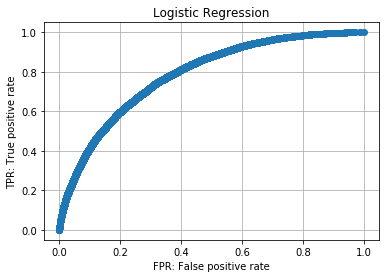

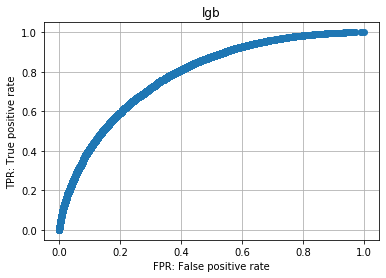

In [6]:
print('plot ROC')

%time
from sklearn.metrics import auc

plot_roc(val_y, val_y_predicted_by_LR, 'Logistic Regression')
plot_roc(val_y, val_y_predicted_by_lgb, 'lgb')

ensemble: 0.7862819103553592


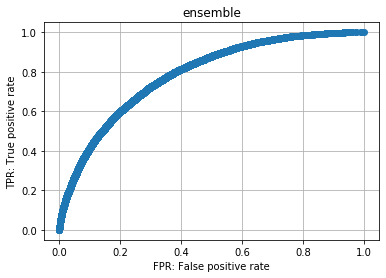

In [10]:
val_y_predicted_ensemble = pd.DataFrame({
    'LR': val_y_predicted_by_LR,
    'lgb': val_y_predicted_by_lgb,
})

test_y_predicted_ensemble = pd.DataFrame({
    'LR': test_y_predicted_by_LR,
    'lgb': test_y_predicted_by_lgb,
})

val_y_predicted_ensemble['mean'] = val_y_predicted_ensemble.mean(axis=1)
test_y_predicted_ensemble['mean'] = test_y_predicted_ensemble.mean(axis=1)

plot_roc(val_y, val_y_predicted_ensemble['mean'], 'ensemble')

In [13]:
import numpy as np
sample_submission['target'] = np.array(test_y_predicted_ensemble['mean'])
sample_submission.to_csv("../datas/cat-in-the-dat-ii/submission_20200224.csv")
